# 8. Vector Autoregression (VAR)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts

from datetime import datetime, timedelta

In [2]:
pip install yfinance

  Obtaining dependency information for yfinance from https://files.pythonhosted.org/packages/14/03/3c854ca3e02eedf614abba4b2e177c469bf3af58207fa30d5098c5d652fe/yfinance-0.2.37-py2.py3-none-any.whl.metadata
  Obtaining dependency information for multitasking>=0.0.7 from https://files.pythonhosted.org/packages/3e/8a/bb3160e76e844db9e69a413f055818969c8acade64e1a9ac5ce9dfdcf6c1/multitasking-0.0.11-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/314.6 kB ? eta -:--:--
     --- ----------------------------------- 30.7/314.6 kB 1.3 MB/s eta 0:00:01
     -------------------------------------  307.2/314.6 kB 4.8 MB/s eta 0:00:01
     -------------------------------------- 314.6/314.6 kB 3.2 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
 

In [3]:
import yfinance as yf

In [7]:
start =  datetime(2013,1,1)
end = datetime(2023,12,31)

aapl = yf.download('AAPL', start, end) 
aapl.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,19.779285,19.821428,19.343929,19.608213,16.747717,560518000
2013-01-03,19.567142,19.631071,19.321428,19.360714,16.536327,352965200
2013-01-04,19.177500,19.236786,18.779642,18.821428,16.075716,594333600
2013-01-07,18.642857,18.903570,18.400000,18.710714,15.981158,484156400
2013-01-08,18.900356,18.996071,18.616072,18.761070,16.024164,458707200


<Axes: xlabel='Date'>

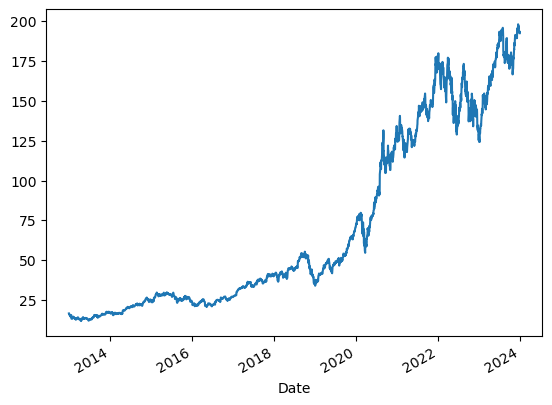

In [8]:
aapl['Adj Close'].plot()

In [9]:
pip install pandas_datareader

  Obtaining dependency information for pandas_datareader from https://files.pythonhosted.org/packages/3f/16/56c9d648b503619ebe96f726b5f642b68e299b34162ed2d6faa9d7966b7d/pandas_datareader-0.10.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/109.5 kB ? eta -:--:--
   --- ------------------------------------ 10.2/109.5 kB ? eta -:--:--
   ---------- ---------------------------- 30.7/109.5 kB 435.7 kB/s eta 0:00:01
   ------------------------------------- -- 102.4/109.5 kB 1.2 MB/s eta 0:00:01
   -------------------------------------- 109.5/109.5 kB 910.3 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [10]:
from pandas_datareader import data

In [12]:
start = datetime(1985,1,1)
end = datetime(2019,12,31)

gdpdata = data.DataReader('GDPC1', data_source = "fred", start=start, end=end)  #getting data from FRED
gdpdata['gdpgr']=gdpdata.GDPC1.pct_change()*100
gdpdata.head(3)

,GDPC1,gdpgr
DATE,,
1985-01-01,8400.820,NaN
1985-04-01,8474.787,0.880474
1985-07-01,8604.220,1.527271


In [14]:
ratedata= data.DataReader('TB3MS', data_source='fred', start=start, end=end) #this data is montlydata
rate_q = ratedata.resample('3M', axis=0).last()   #resampling for quarterly data
rate_q.head(3)

,TB3MS
DATE,
1985-01-31,7.76
1985-04-30,7.95
1985-07-31,7.08


In [15]:
gdpdata.index = gdpdata.index.to_period('M').to_timestamp('M')

df = gdpdata
df['rate'] = rate_q['TB3MS']
df.head()

,GDPC1,gdpgr,rate
DATE,,,
1985-01-31,8400.820,NaN,7.76
1985-04-30,8474.787,0.880474,7.95
1985-07-31,8604.220,1.527271,7.08
1985-10-31,8668.188,0.743449,7.16
1986-01-31,8749.127,0.933748,7.07


<Axes: xlabel='DATE'>

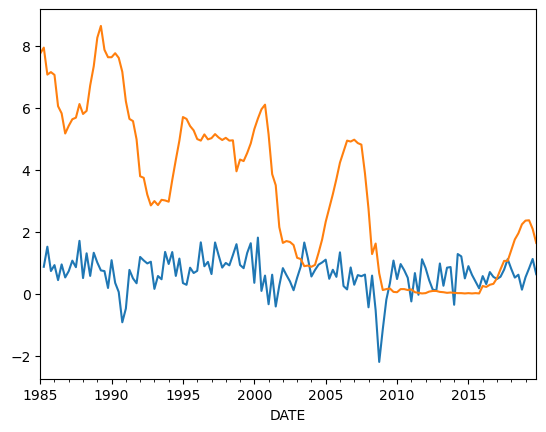

In [16]:
df.gdpgr.plot()
df.rate.plot()  #not stationary--> need to use the difference

In [17]:
df['drate'] = df.rate.diff()
df.head()

,GDPC1,gdpgr,rate,drate
DATE,,,,
1985-01-31,8400.820,NaN,7.76,NaN
1985-04-30,8474.787,0.880474,7.95,0.19
1985-07-31,8604.220,1.527271,7.08,-0.87
1985-10-31,8668.188,0.743449,7.16,0.08
1986-01-31,8749.127,0.933748,7.07,-0.09


<Axes: xlabel='DATE'>

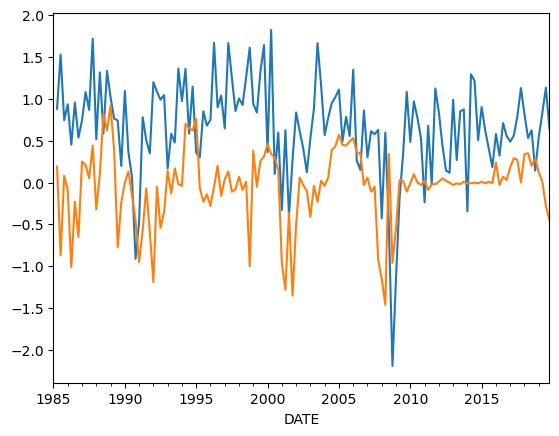

In [18]:
df.gdpgr.plot()
df.drate.plot()

In [19]:
#ADF test to check stationary
sts.adfuller(df.drate[1:])   #non-stationary hypothesis is rejected--> the variable is stationary

(-5.031559846551169,
 1.9213182942815076e-05,
 1,
 137,
 {'1%': -3.479007355368944,
  '5%': -2.8828782366015093,
  '10%': -2.5781488587564603},
 106.02672840472405)

In [20]:
#Now we can build our model since the variables are stationary
from statsmodels.tsa.api import VAR

In [21]:
vardf = df[['gdpgr','drate']][1:] #creating a new data frame w/ variables that I want
vardf.head(3)

,gdpgr,drate
DATE,,
1985-04-30,0.880474,0.19
1985-07-31,1.527271,-0.87
1985-10-31,0.743449,0.08


In [22]:
model =  VAR(vardf)
results = model.fit(maxlags=3)  #the drate lags do not granger cause the gdpgr
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 18, Mar, 2024
Time:                     16:28:48
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -2.94407
Nobs:                     136.000    HQIC:                  -3.12205
Log likelihood:          -151.366    FPE:                  0.0390186
AIC:                     -3.24390    Det(Omega_mle):       0.0352921
--------------------------------------------------------------------
Results for equation gdpgr
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.369808         0.090389            4.091           0.000
L1.gdpgr         0.292709         0.088467            3.309           0.001
L1.drate        -0.081174         0.127402           -0.637           0.524
L2.g

In [24]:
modelcomp = model.select_order(maxlags=12)
modelcomp.summary()   #based on AIC the order 2 is optimal, based on BIC the order 1 is optimal

,AIC,BIC,FPE,HQIC
0,-2.834,-2.789,0.05877,-2.816
1,-3.299,-3.165*,0.03692,-3.245*
2,-3.333*,-3.109,0.03570*,-3.242
3,-3.282,-2.969,0.03755,-3.155
4,-3.256,-2.853,0.03857,-3.092
5,-3.202,-2.709,0.04074,-3.001
6,-3.235,-2.653,0.03941,-2.999
7,-3.198,-2.526,0.04093,-2.925
8,-3.159,-2.398,0.04261,-2.850
9,-3.170,-2.319,0.04219,-2.824


<Axes: xlabel='DATE'>

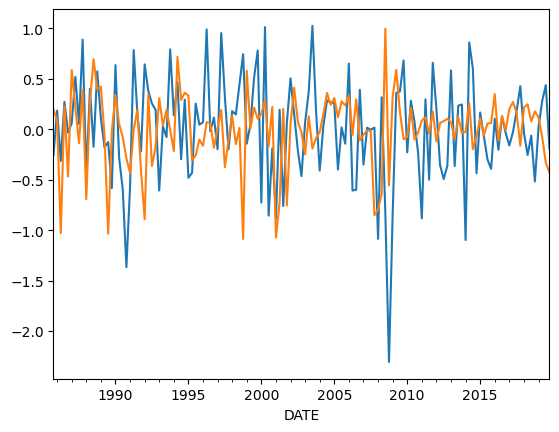

In [25]:
# Assume that the order 2 is the optimal model
# Check the residuals
model = VAR(vardf)
results = model.fit(maxlags=2)
results.resid.gdpgr.plot()
results.resid.drate.plot()  #no trend, kind of look like white noise bt further analysis is needed.

Text(0.5, 1.0, 'PACF for gdpgr residuals')

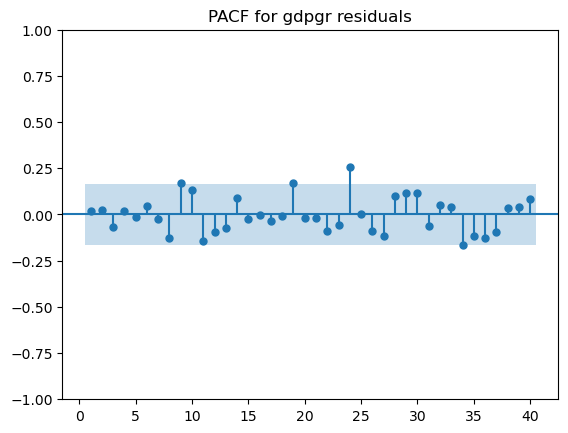

In [26]:
sgt.plot_pacf(results.resid.gdpgr, lags=40, zero= False, method ='ols')
plt.title('PACF for gdpgr residuals') # there is no correlation structure within the residuals which is good.

In [27]:
#Now, Forecasting
train = vardf[:-4]
test = vardf[-4:]

model = VAR(train)
lags = 2
results = model.fit(maxlags=lags)

In [28]:
train.tail()

,gdpgr,drate
DATE,,
2017-10-31,1.127047,0.00
2018-01-31,0.813410,0.34
2018-04-30,0.530825,0.35
2018-07-31,0.623697,0.20
2018-10-31,0.141644,0.29


In [29]:
fcinput = train.values[-1*lags:]
fcinput

array([[0.62369743, 0.2       ],
       [0.14164422, 0.29      ]])

In [30]:
fc = results.forecast(y=fcinput, steps = 4)
fc

array([[ 0.51556479,  0.00163983],
       [ 0.53502552,  0.04342887],
       [ 0.58502082, -0.01585835],
       [ 0.61075482, -0.01892778]])

In [32]:
df_fc=pd.DataFrame(fc, index=test.index, columns=test.columns)
df_fc

,gdpgr,drate
DATE,,
2019-01-31,0.515565,0.001640
2019-04-30,0.535026,0.043429
2019-07-31,0.585021,-0.015858
2019-10-31,0.610755,-0.018928


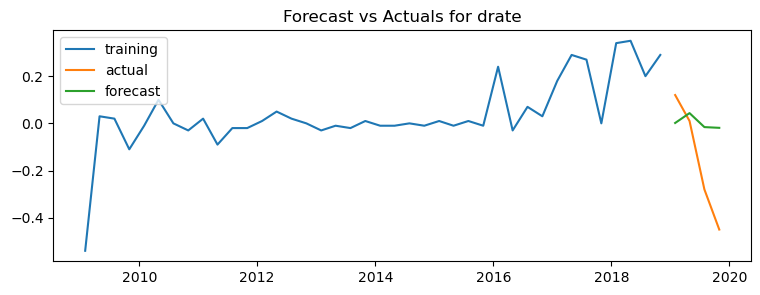

In [33]:
plt.figure(figsize=(9,3))
plt.plot(train.drate[-40:], label='training')
plt.plot(test.drate, label='actual')
plt.plot(df_fc.drate, label='forecast')
plt.title('Forecast vs Actuals for drate')
plt.legend(loc='upper left', fontsize=10)

In [35]:
# the graph is wierd bc we use the difference of the rates --> we should reverse transform(change) it back to rate 
train['rate'] =  df.rate[1:-4]
test['rate'] = df.rate[-4:]
df_fc['rate'] = train.rate.iloc[-1] + df_fc.drate.cumsum()  #cumulative sum
df_fc

C:\Users\soyyo\AppData\Local\Temp\ipykernel_32060\1775723869.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['rate'] =  df.rate[1:-4]
C:\Users\soyyo\AppData\Local\Temp\ipykernel_32060\1775723869.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['rate'] = df.rate[-4:]


,gdpgr,drate,rate
DATE,,,
2019-01-31,0.515565,0.001640,2.251640
2019-04-30,0.535026,0.043429,2.295069
2019-07-31,0.585021,-0.015858,2.279210
2019-10-31,0.610755,-0.018928,2.260283


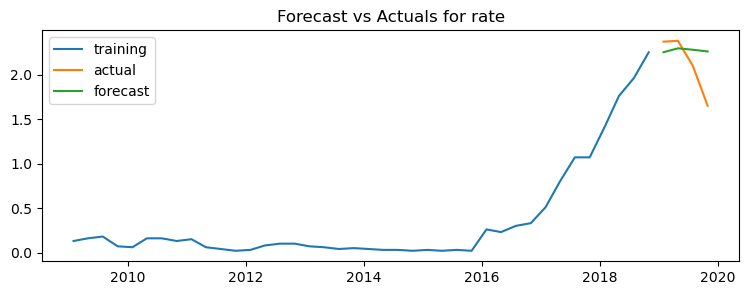

In [36]:
plt.figure(figsize=(9,3))
plt.plot(train.rate[-40:], label='training')
plt.plot(test.rate, label='actual')
plt.plot(df_fc.rate, label='forecast')
plt.title('Forecast vs Actuals for rate')
plt.legend(loc='upper left', fontsize=10)

In [37]:
#Finally, the granger causality
from statsmodels.tsa.stattools import grangercausalitytests

In [38]:
df_gc = pd.DataFrame({'drate':df.drate[1:],
                     'gdpgr':df.gdpgr[1:]})
df_gc.head(3)  #will have to create another df to see the vice versa relation, this one check a lag in gdpgr affects the drate

,drate,gdpgr
DATE,,
1985-04-30,0.19,0.880474
1985-07-31,-0.87,1.527271
1985-10-31,0.08,0.743449


In [39]:
gc_results = grangercausalitytests(df_gc,2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.1383 , p=0.0004  , df_denom=135, df_num=1
ssr based chi2 test:   chi2=13.4302 , p=0.0002  , df=1
likelihood ratio test: chi2=12.8163 , p=0.0003  , df=1
parameter F test:         F=13.1383 , p=0.0004  , df_denom=135, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.4937  , p=0.0008  , df_denom=132, df_num=2
ssr based chi2 test:   chi2=15.5551 , p=0.0004  , df=2
likelihood ratio test: chi2=14.7336 , p=0.0006  , df=2
parameter F test:         F=7.4937  , p=0.0008  , df_denom=132, df_num=2


In [40]:
df_gc2 = pd.DataFrame({'gdpgr':df.gdpgr[1:],
                       'drate':df.drate[1:]})
df_gc2.head(3)

,gdpgr,drate
DATE,,
1985-04-30,0.880474,0.19
1985-07-31,1.527271,-0.87
1985-10-31,0.743449,0.08


In [41]:
gc_results = grangercausalitytests(df_gc2,2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0609  , p=0.3049  , df_denom=135, df_num=1
ssr based chi2 test:   chi2=1.0845  , p=0.2977  , df=1
likelihood ratio test: chi2=1.0802  , p=0.2986  , df=1
parameter F test:         F=1.0609  , p=0.3049  , df_denom=135, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6642  , p=0.5164  , df_denom=132, df_num=2
ssr based chi2 test:   chi2=1.3787  , p=0.5019  , df=2
likelihood ratio test: chi2=1.3718  , p=0.5036  , df=2
parameter F test:         F=0.6642  , p=0.5164  , df_denom=132, df_num=2
